<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone: Network Traffic Classification

**Project notebooks:**<br>
1 - [Data Import and Cleansing](./01_Data_import_cleaning)<br>
2 - [Exploratory Data Analysis](./02_EDA)<br>
3 - Preprocessing and Modeling(current notebook)

### Data import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
import shap

pd.set_option('display.max_columns', None)

In [2]:
#load dataset 
train = joblib.load('../dataset/s1_final_train.pickle')
test = joblib.load('../dataset/s1_final_test.pickle')

In [3]:
display(train.shape)
display(test.shape)

(103158, 33)

(928137, 33)

### Pre-processing

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

In [5]:
# Create X and y
X = train.drop(['label'], axis=1)
y = train['label']

test_x = test.drop(['label'], axis=1)
test_y = test['label']

display(X.shape, y.shape)
display(test_x.shape, test_y.shape)

(103158, 32)

(103158,)

(928137, 32)

(928137,)

In [6]:
# Create train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

In [7]:
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(72210, 32)

(30948, 32)

(72210,)

(30948,)

### Baseline accuracy

In [8]:
y_test.value_counts(normalize=True)

0    0.916117
1    0.083883
Name: label, dtype: float64

In [9]:
#dummy categorical cols
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

enc.fit(X_train.select_dtypes(include="object"))

enc_X_train = pd.DataFrame(
    enc.transform(X_train.select_dtypes(include="object")),
    columns=enc.get_feature_names_out(),
)

enc_X_test = pd.DataFrame(
    enc.transform(X_test.select_dtypes(include="object")),
    columns=enc.get_feature_names_out(),
)

enc_X_train.index = X_train.index
enc_X_test.index = X_test.index

In [11]:
display(enc_X_train.shape)
display(enc_X_test.shape)

(72210, 15)

(30948, 15)

In [12]:
# Scale numerical cols
MMsc = MinMaxScaler()
MMsc.fit(X_train.select_dtypes(exclude=object))

MM_X_train = pd.DataFrame(MMsc.transform(X_train.select_dtypes(exclude=object)),
    columns=MMsc.get_feature_names_out())

MM_X_test = pd.DataFrame(MMsc.transform(X_test.select_dtypes(exclude=object)),
    columns=MMsc.get_feature_names_out())

MM_X_train.index = X_train.index
MM_X_test.index = X_test.index

In [13]:
#combine df for MinMax Scalar
new_X_train = pd.concat([enc_X_train, MM_X_train], axis=1)
new_X_test = pd.concat([enc_X_test, MM_X_test], axis=1)

In [14]:
display(new_X_train.shape)
display(new_X_test.shape)

(72210, 44)

(30948, 44)

### Pipelines and Parameters

In [30]:
# Import libraries
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, recall_score, precision_score, roc_curve, roc_auc_score, PrecisionRecallDisplay, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

### Pipeline and Hyperparameter Tuning

In [16]:
#catboost
pipe_cat = Pipeline([('cat', CatBoostClassifier(verbose= False))])

# XGBoost      
pipe_xgb = Pipeline([('xgb', XGBClassifier(n_jobs=-1))])

# AdaBoost      
pipe_ada = Pipeline([('ada', AdaBoostClassifier())])

In [28]:
params_cat = {
    'cat__depth': [5,7],
    'cat__learning_rate' : [0.1, 0.05, 0.01],
    'cat__iterations': [450,500, 550],
    'cat__auto_class_weights' : ['Balanced']
}

params_ada = {
    'ada__n_estimators': [250,300, 350],
    'ada__learning_rate' : [0.1, 0.05, 0.01]
}

params_xgb = {
    'xgb__n_estimators': [60, 80, 100],
    'xgb__eta' : [1, 0.1, 0.01],
    'xgb__max_depth' : [5,7],
    'xgb__eval_metric' : ['auc']
}


### Modelling

In [18]:
def model_fit(model_name, X_train, y_train, pipe, param):
    
    gs = GridSearchCV(pipe, param, cv=3, scoring = 'f1', n_jobs=-1)
    gs.fit(X_train, y_train)
    
    filename = f'../model/{model_name}.pickle'
    joblib.dump(gs.best_estimator_, filename)

    print(gs.best_params_)

In [19]:
def model_plot(df, model_name, X_train, X_test, y_train, y_test):
    
    #load model
    filename = f'../model/{model_name}.pickle'
    model = joblib.load(filename)
    
    # check for generalisation
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    #train scoring
    train_accuracy = round(accuracy_score(y_train, y_train_pred),3)
    train_recall = round(recall_score(y_train, y_train_pred),3)
    train_f1 = round(f1_score(y_train, y_train_pred),3)
    train_precision = round(precision_score(y_train, y_train_pred),3)
    train_roc_auc = round(roc_auc_score(y_train, y_train_pred),3)
    
    #test scoring
    test_accuracy = round(accuracy_score(y_test, y_test_pred),3)
    test_recall = round(recall_score(y_test, y_test_pred),3)
    test_f1 = round(f1_score(y_test, y_test_pred),3)
    test_precision = round(precision_score(y_test, y_test_pred),3)
    test_roc_auc = round(roc_auc_score(y_test, y_test_pred),3)
    
    #generalisation
    gen_accuracy = round(((train_accuracy - test_accuracy)/train_accuracy * 100),3)
    gen_recall = round(((train_recall - test_recall)/train_recall * 100),3)
    gen_f1 = round(((train_f1 - test_f1)/train_f1 * 100),3)
    gen_precision = round(((train_precision - test_precision)/train_precision * 100),3)
    gen_roc_auc = round(((train_roc_auc - test_roc_auc)/train_roc_auc * 100),3)
    
    #get predicted data points to plot the roc curve
    y_proba = model.predict_proba(X_test)
    
    # roc curve for models
    fpr, tpr, thresh = roc_curve(y_test, y_proba[:, 1])
    
    # precision-recall curve for models
    precision, recall, threshold = precision_recall_curve(y_test, y_proba[:, 1])

    #store values as dictionary
    data = {"model" : model_name,
            "train_accuracy" : train_accuracy, 
            "train_recall" : train_recall,
            "train_precision" : train_precision, 
            "train_f1": train_f1, 
            "train_roc_auc" : train_roc_auc, 
            "test_accuracy" : test_accuracy, 
            "test_recall" : test_recall,
            "test_precision" : test_precision, 
            "test_f1": test_f1, 
            "test_roc_auc" : test_roc_auc,
            "gen_accuracy" : gen_accuracy, 
            "gen_recall" : gen_recall,
            "gen_precision" : gen_precision, 
            "gen_f1": gen_f1, 
            "gen_roc_auc" : gen_roc_auc,
            "best_params" : model,
            "fpr" : [fpr], 
            "tpr" : [tpr],
            "precision" : [precision], 
            "recall" : [recall],
           }
    
    # Create DataFrame
    result = pd.DataFrame(data)

    #append to original df
    result = pd.concat([df, result], ignore_index=True)
    
    print(model)
    
    print('Classification Report')
    print(classification_report(y_test,y_test_pred))
    print('Confusion Matrix')
    #plot confusion matrix 
    fig, ax = plt.subplots(1, 2, figsize = (8, 4))
    
    cm1 = confusion_matrix(y_train, y_train_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm1, 
                               display_labels=['normal', 'malicious']).plot( ax = ax[0], values_format='d', 
                                                                        colorbar = False, cmap='YlGn')  
                                #0 is normal, 1 is malicious

    ax[0].set_title(f'Train - {model_name}')
    
    cm2 = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm2, 
                               display_labels=['normal', 'malicious']).plot(ax = ax[1], values_format='d', 
                                                                        colorbar = False, cmap='YlGn')  
    
    ax[1].set_title(f'Test - {model_name}')   

    plt.tight_layout()
    plt.show()
    
    TN = cm2[0][0]
    FP = cm2[0][1]
    FN = cm2[1][0]
    TP = cm2[1][1]
    
    
    print(f'Train f1: {train_f1}')
    print(f'Test f1: {test_f1}')
    print(f'f1 generalisation: {gen_f1}')
    print(f'Test FAR: {round((FP/(FP+TN)*100),2)}%')
    print(f'Test FNR: {round((FN/(TP+FN)*100),2)}%')
      
    return result

### Find the best estimators

In [23]:
%time model_fit('cat', new_X_train, y_train, pipe_cat, params_cat)

/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from p

{'cat__auto_class_weights': 'Balanced', 'cat__depth': 7, 'cat__iterations': 500, 'cat__learning_rate': 0.1}
CPU times: user 33.7 s, sys: 2.13 s, total: 35.9 s
Wall time: 7min 11s


In [29]:
%time model_fit('ada', new_X_train, y_train, pipe_ada, params_ada)

{'ada__learning_rate': 0.1, 'ada__n_estimators': 350}
CPU times: user 58.7 s, sys: 1.92 s, total: 1min
Wall time: 10min 19s


In [25]:
%time model_fit('xgb', new_X_train, y_train, pipe_xgb, params_xgb)

/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-p

/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/coremptiness/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

{'xgb__eta': 0.1, 'xgb__eval_metric': 'auc', 'xgb__max_depth': 5, 'xgb__n_estimators': 80}
CPU times: user 40.9 s, sys: 979 ms, total: 41.8 s
Wall time: 9min 47s


In [31]:
#define empty dataframe to store the results
result = pd.DataFrame()

Pipeline(steps=[('ada',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=350))])
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     28352
           1       0.88      0.92      0.90      2596

    accuracy                           0.98     30948
   macro avg       0.94      0.96      0.95     30948
weighted avg       0.98      0.98      0.98     30948

Confusion Matrix


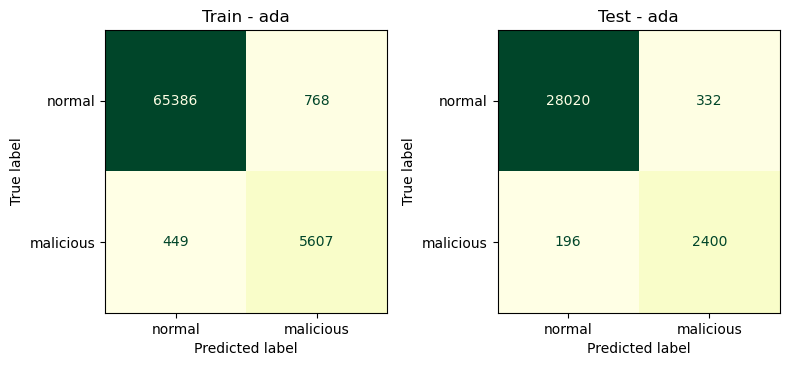

Train f1: 0.902
Test f1: 0.901
f1 generalisation: 0.111
Test FAR: 1.17%
Test FNR: 7.55%


In [32]:
#Model 1: ada
result = model_plot(result, 'ada', new_X_train, new_X_test, y_train, y_test)

Pipeline(steps=[('cat',
                 <catboost.core.CatBoostClassifier object at 0x7ff0c76532e0>)])
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     28352
           1       0.82      0.99      0.89      2596

    accuracy                           0.98     30948
   macro avg       0.91      0.98      0.94     30948
weighted avg       0.98      0.98      0.98     30948

Confusion Matrix


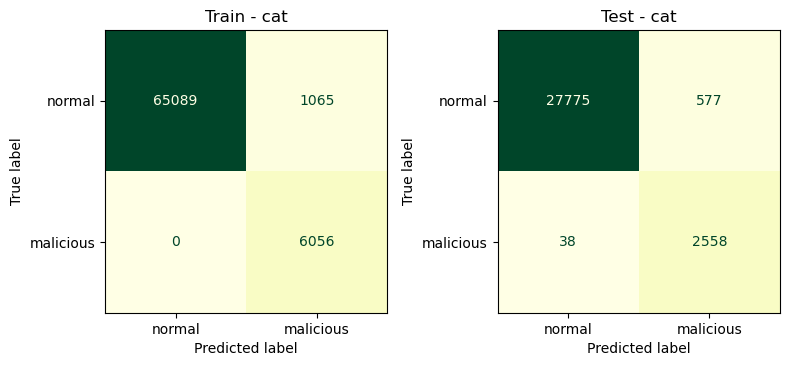

Train f1: 0.919
Test f1: 0.893
f1 generalisation: 2.829
Test FAR: 2.04%
Test FNR: 1.46%


In [33]:
#Model 2: cat
result = model_plot(result, 'cat', new_X_train, new_X_test, y_train, y_test)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eta=0.1, eval_metric='auc', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.100000001, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=80,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])
Classification Report
        

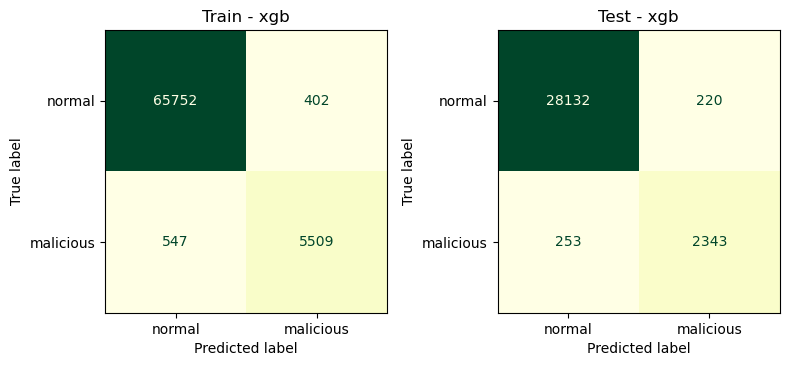

Train f1: 0.921
Test f1: 0.908
f1 generalisation: 1.412
Test FAR: 0.78%
Test FNR: 9.75%


In [34]:
#Model 3: xgb
result = model_plot(result, 'xgb', new_X_train, new_X_test, y_train, y_test)

In [35]:
result

,model,train_accuracy,train_recall,train_precision,train_f1,train_roc_auc,test_accuracy,test_recall,test_precision,test_f1,test_roc_auc,gen_accuracy,gen_recall,gen_precision,gen_f1,gen_roc_auc,best_params,fpr,tpr,precision,recall
0,ada,0.983,0.926,0.880,0.902,0.957,0.983,0.924,0.878,0.901,0.956,0.000,0.216,0.227,0.111,0.104,"((DecisionTreeClassifier(max_depth=1, random_s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.1721879815100154, 0.17565485362095531,...","[0.08388264185084658, 0.08389077395378898, 0.0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,cat,0.985,1.000,0.850,0.919,0.992,0.980,0.985,0.816,0.893,0.983,0.508,1.500,4.000,2.829,0.907,(<catboost.core.CatBoostClassifier object at 0...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0003852080123266564, 0.050077041602465...","[0.08388264185084658, 0.08388535237664393, 0.0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,xgb,0.987,0.910,0.932,0.921,0.952,0.985,0.903,0.914,0.908,0.947,0.203,0.769,1.931,1.412,0.525,"(XGBClassifier(base_score=0.5, booster='gbtree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.03697996918335902, 0.03813559322033898...","[0.08388264185084658, 0.5033934458018228, 0.50...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


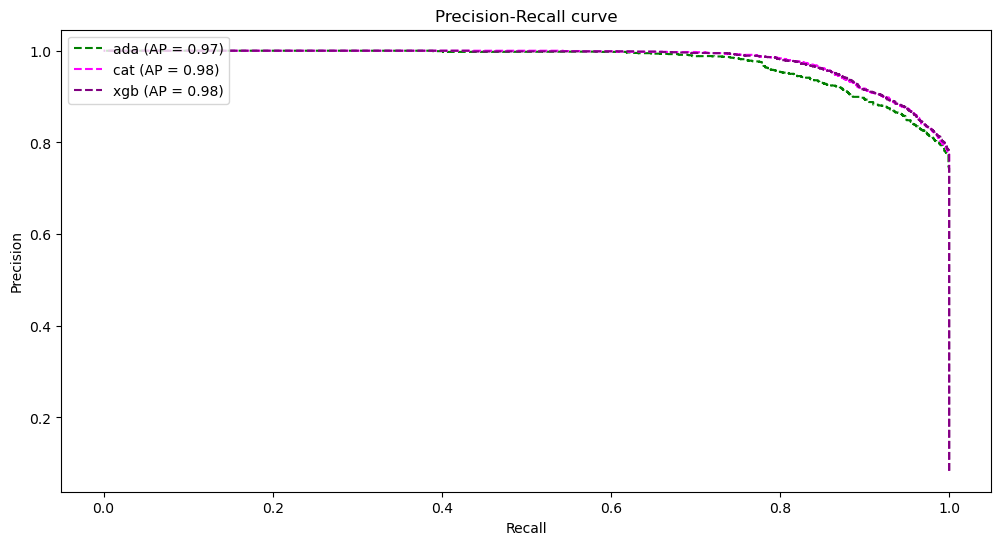

In [74]:
#Precision-Recall Curve
fig, ax = plt.subplots(figsize = (12,6))

color = ['green','magenta','purple','red','orange','cyan']

# plot PR curves
for i in range(len(result)):

    name = result['model'][i]    
    model = joblib.load(f'../model/{name}.pickle')
    #plt.plot(result['precision'][i], result['recall'][i], linestyle='--',color=color[i], label=f"{result['model'][i]}")
    
    PrecisionRecallDisplay.from_estimator(model, new_X_test, y_test, name=result['model'][i], linestyle='--',color=color[i], ax=ax)
    
#plot baseline
# baseline = len(y_test[y_test==1]) / len(y_test)
# plt.axhline(y= baseline, linestyle='-.', label = f"Baseline {round(baseline,2)}")

plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc='upper left')
plt.show();

Based on the results, all three models generalised quite well (no overfitting) based on the variance in F1 score between the train and test data. The models also have similar precision-recall score. Hence, we will choose the model with the best FNR and FPR.

The CatBoost model is selected as it is the fastest and has the best recall score. We want the best recall score as we aimed to reduce the number of false negative (ie classifying attack as normal traffic). This is also shown from the low FNR of 1.46% Whilst the CatBoost model has the highest FPR among the models, this is a compromise of having a low FNR.

### Test the model with the holdout dataset

In [49]:
#dummy categorical cols
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

enc.fit(X.select_dtypes(include="object"))

enc_train = pd.DataFrame(
    enc.transform(X.select_dtypes(include="object")),
    columns=enc.get_feature_names_out(),
)

enc_test = pd.DataFrame(
    enc.transform(test_x.select_dtypes(include="object")),
    columns=enc.get_feature_names_out(),
)

enc_train.index = X.index
enc_test.index = test_x.index

In [50]:
display(enc_train.shape)
display(enc_test.shape)

(103158, 15)

(928137, 15)

In [51]:
# Scale numerical cols
MMsc = MinMaxScaler()

MMsc.fit(X.select_dtypes(exclude=object))

MM_train = pd.DataFrame(MMsc.transform(X.select_dtypes(exclude=object)),
    columns=MMsc.get_feature_names_out())

MM_test = pd.DataFrame(MMsc.transform(test_x.select_dtypes(exclude=object)),
    columns=MMsc.get_feature_names_out())

MM_train.index = X.index
MM_test.index = test_x.index

In [52]:
#combine df for MinMax Scalar
new_train = pd.concat([enc_train, MM_train], axis=1)
new_test = pd.concat([enc_test, MM_test], axis=1)

In [53]:
display(new_train.shape)
display(new_test.shape)

(103158, 44)

(928137, 44)

In [54]:
cat = CatBoostClassifier(verbose= False, 
                         auto_class_weights = 'Balanced', 
                         depth =  7, iterations = 500, 
                         learning_rate =  0.1)

In [55]:
%time cat.fit(new_train, y)

CPU times: user 32.5 s, sys: 1.72 s, total: 34.2 s
Wall time: 13.1 s


In [56]:
test_pred = cat.predict(new_test)

In [57]:
y_check = pd.DataFrame()
y_check['Original'] = test_y
y_check['Predict'] = test_pred

Test FAR: 2.45%
Test FNR: 0.54%


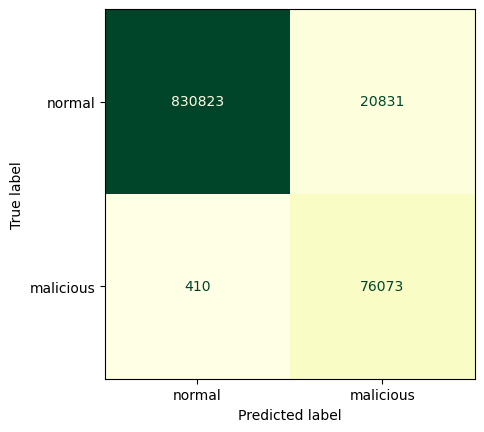

In [58]:
#Baseline confusion matrix
cm = confusion_matrix(y_check['Original'], y_check['Predict'])

ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=['normal', 'malicious']).plot(values_format='d', 
                                                                    colorbar = False, cmap='YlGn') 
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]
    
print(f'Test FAR: {round((FP/(FP+TN)*100),2)}%')
print(f'Test FNR: {round((FN/(TP+FN)*100),2)}%')


plt.show()

### Feature Importance

In [59]:
#load best model
best = joblib.load('../model/s1_cat.pickle') 

In [60]:
sv_filename = f'../model/shap_values.pickle'

In [ ]:
# Fits the explainer
explainer = shap.Explainer(best.predict, new_X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(new_X_test)
joblib.dump(shap_values, sv_filename)

In [61]:
shap_values = joblib.load(sv_filename) 

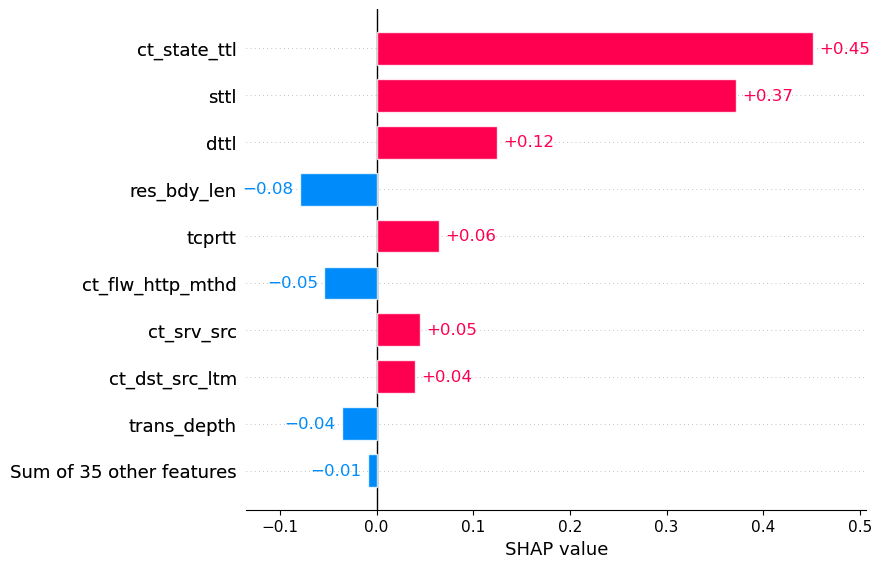

In [72]:
shap.plots.bar(shap_values[0])